In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/space-missions-v3.csv')
print(df.head())
# Loaded here: https://www.kaggle.com/code/carlosmunozkampff/notebook831c35ceb1 and digested to this data:
# Data
data_yearly = {
    'Year': [1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'Number of Missions': [3, 28, 20, 39, 52, 82, 41, 60, 87, 101, 106, 103, 103, 107, 119, 99, 103, 98, 113, 113, 114, 97, 49, 55, 71, 67, 66, 69, 74, 62, 56, 59, 52, 80, 59, 62, 61, 64, 61, 60, 70, 68, 57, 57, 43, 49, 52, 40, 37, 49, 50, 48, 50, 37, 42, 38, 46, 53, 52, 90, 92, 117, 109, 119, 157, 93]
}

     Company                                   Location       Date      Time  \
0  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  10/4/1957  19:28:00   
1  RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan  11/3/1957   2:30:00   
2    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA  12/6/1957  16:44:00   
3       AMBA   LC-26A, Cape Canaveral AFS, Florida, USA   2/1/1958   3:48:00   
4    US Navy   LC-18A, Cape Canaveral AFS, Florida, USA   2/5/1958   7:33:00   

           Rocket         Mission RocketStatus Price MissionStatus  
0  Sputnik 8K71PS       Sputnik-1      Retired   NaN       Success  
1  Sputnik 8K71PS       Sputnik-2      Retired   NaN       Success  
2        Vanguard    Vanguard TV3      Retired   NaN       Failure  
3          Juno I      Explorer 1      Retired   NaN       Success  
4        Vanguard  Vanguard TV3BU      Retired   NaN       Failure  


In [3]:

# Create DataFrame
missions_per_year = pd.DataFrame(data_yearly)

# Convert 'Year' to datetime and set as index
missions_per_year['datetime'] = pd.to_datetime(missions_per_year['Year'], format='%Y')
missions_per_year = missions_per_year.drop('Year', axis=1).set_index('datetime')

# Display the updated DataFrame
print(missions_per_year)


            Number of Missions
datetime                      
1957-01-01                   3
1958-01-01                  28
1959-01-01                  20
1960-01-01                  39
1961-01-01                  52
...                        ...
2018-01-01                 117
2019-01-01                 109
2020-01-01                 119
2021-01-01                 157
2022-01-01                  93

[66 rows x 1 columns]


In [4]:
missions_per_year.head()

Number of Missions
datetime                      
1957-01-01                   3
1958-01-01                  28
1959-01-01                  20
1960-01-01                  39
1961-01-01                  52

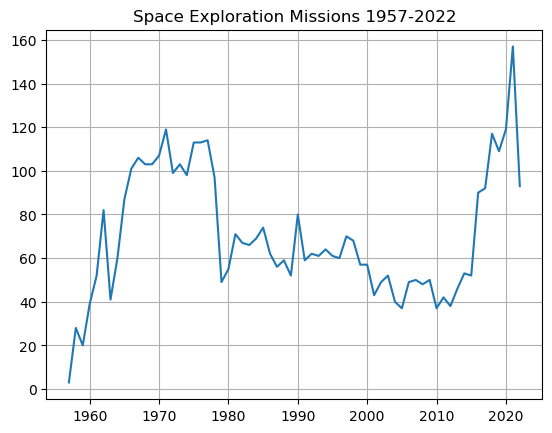

In [5]:
plt.plot(missions_per_year)
plt.title('Space Exploration Missions 1957-2022')
plt.grid();

In [6]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year and quarter from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Group by year and quarter and count the number of launches
launch_counts = df.groupby(['Year', 'Quarter']).size().reset_index(name='LaunchCount')

# Create a new DataFrame with the results
launch_counts_df = pd.DataFrame(launch_counts)

# Create a string representing the start of each quarter
launch_counts_df['QuarterStart'] = launch_counts_df['Year'].astype(str) + 'Q' + launch_counts_df['Quarter'].astype(str)

# Convert this string to a datetime object with a specified format
launch_counts_df['Datetime'] = pd.to_datetime(launch_counts_df['QuarterStart'].apply(lambda x: f"{x[:4]}-{int(x[5])*3-2:02d}-01"))

# Set the datetime column as the index
launch_counts_df.set_index('Datetime', inplace=True)

# Drop the Year, Quarter, and QuarterStart columns as they are now redundant
launch_counts_df.drop(columns=['Year', 'Quarter', 'QuarterStart'], inplace=True)

# Display the new DataFrame
print(launch_counts_df.head())

            LaunchCount
Datetime               
1957-10-01            3
1958-01-01            5
1958-04-01            5
1958-07-01           11
1958-10-01            7


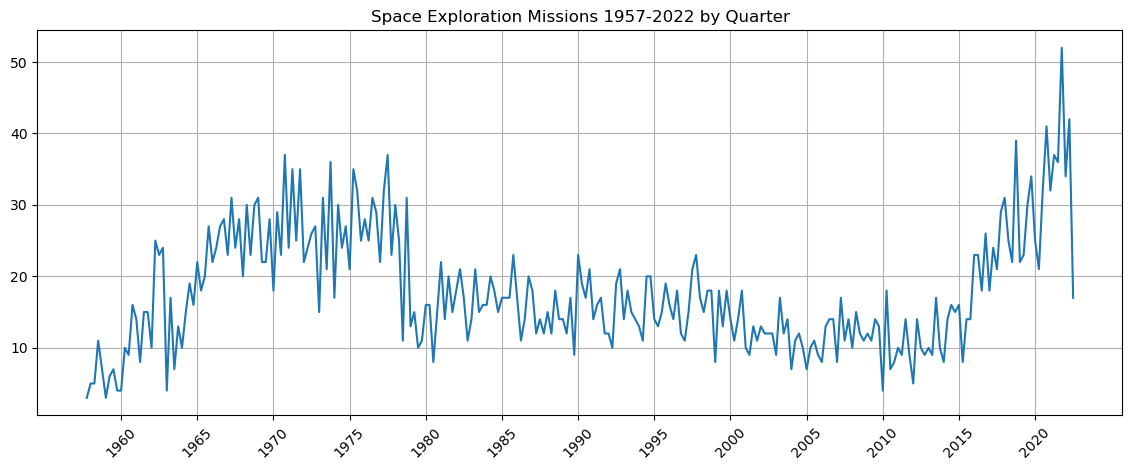

In [7]:
# Create a figure with the specified size
plt.figure(figsize=(14, 5))

# Plot the data
plt.plot(launch_counts_df['LaunchCount'])

# Set the title and grid
plt.title('Space Exploration Missions 1957-2022 by Quarter')
plt.grid()

# Set the x-axis ticks to display every 5 years
years = launch_counts_df.index.year.unique()
five_years = years[years % 5 == 0]
plt.xticks([pd.Timestamp(str(year)) for year in five_years], five_years)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Split historical and future data

In [8]:
y_hist = launch_counts_df.loc['2010':'2019','LaunchCount']
y_future = launch_counts_df.loc['2019':'2022','LaunchCount']

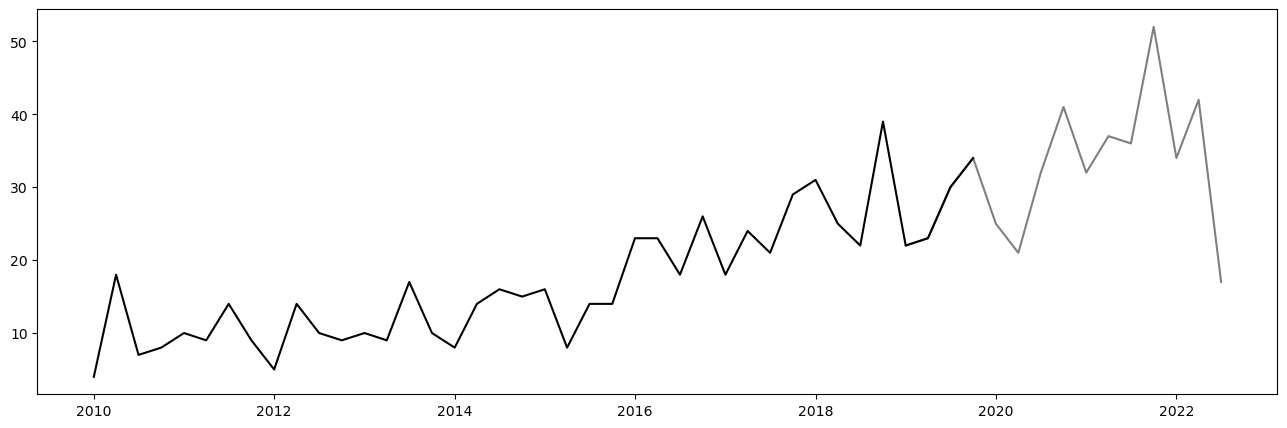

In [9]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)

# Extract the trend


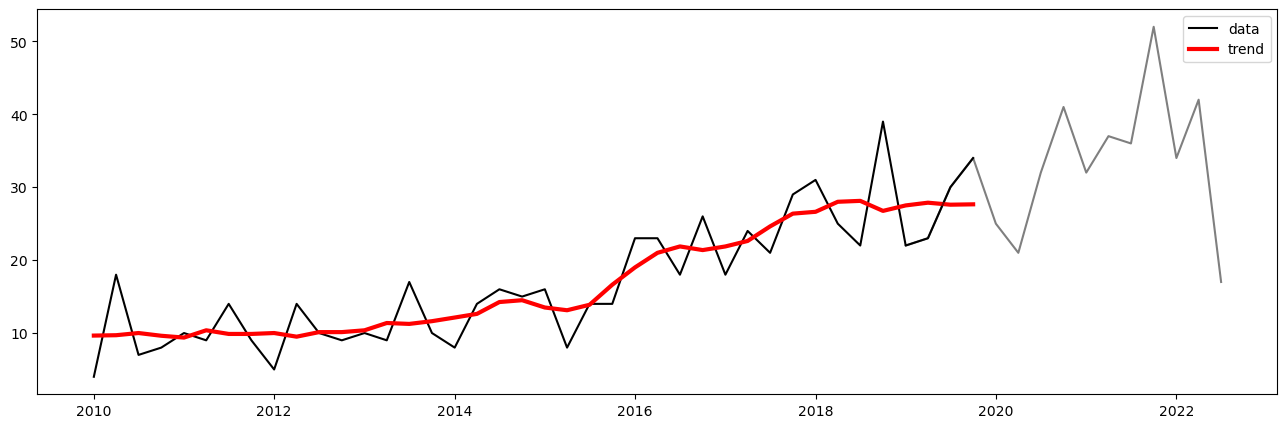

In [10]:
period = 4

filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period

trend = convolution_filter(y_hist, filt)
trend = _extrapolate_trend(trend, period + 1)

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_future,'k',alpha=0.5)
plt.legend()

# Detrended data

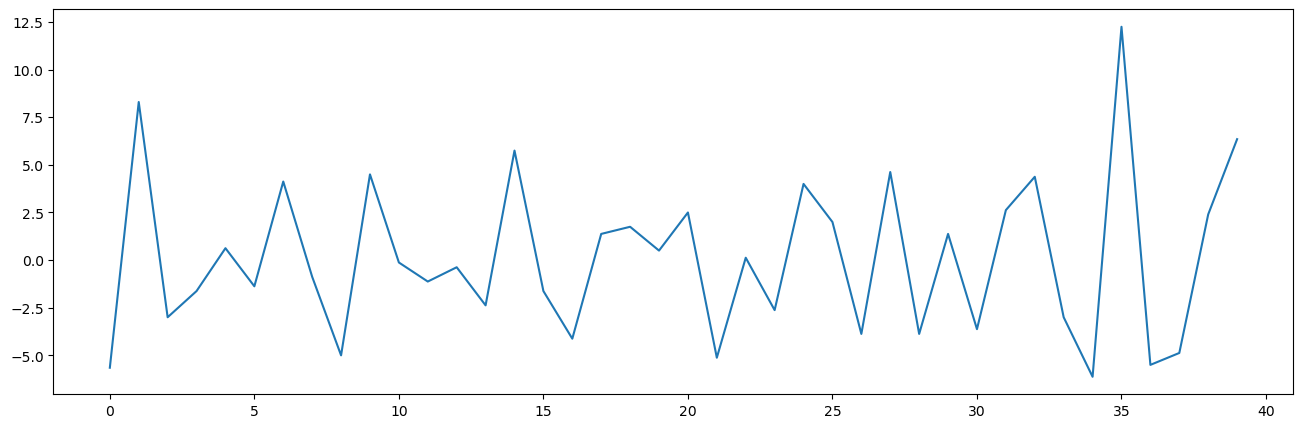

In [11]:
detrended = y_hist - trend
detrended = detrended.to_numpy()

plt.figure(figsize=(16,5))
plt.plot(detrended)

# Split the historical data into seasons

In [12]:
lows_index = [0,2,8,13,16,21,26,30,34,36]
lows = y_hist.index[lows_index]
lows

DatetimeIndex(['2010-01-01', '2010-07-01', '2012-01-01', '2013-04-01',
               '2014-01-01', '2015-04-01', '2016-07-01', '2017-07-01',
               '2018-07-01', '2019-01-01'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

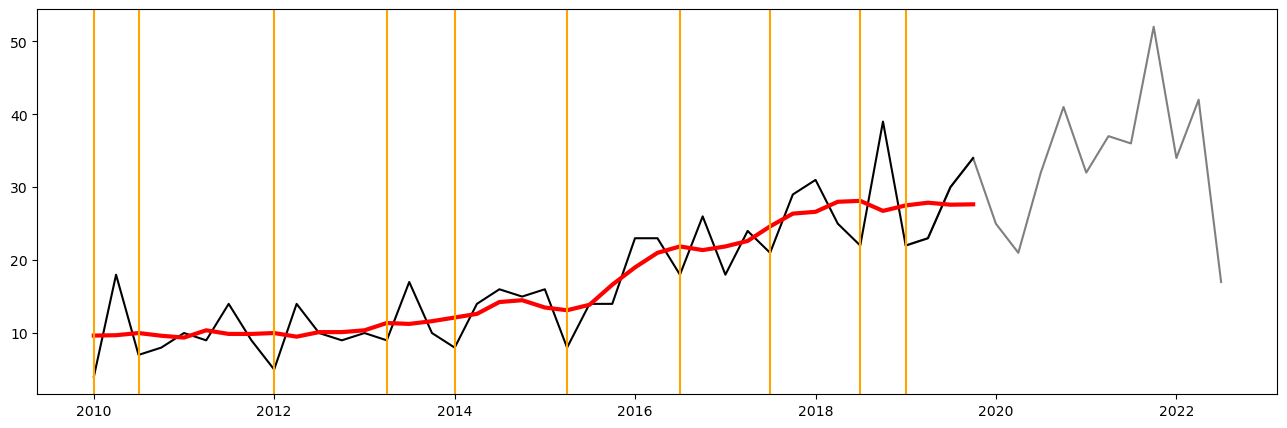

In [13]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)
plt.plot(trend,'r',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

# Divide the detrended data into seasons

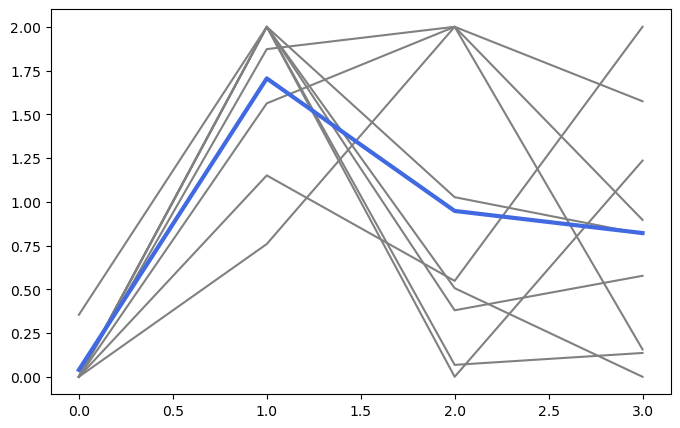

In [14]:
period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows)-1    
seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

In [15]:
# Extract the quarter from the Datetime index
launch_counts_df['Quarter'] = launch_counts_df.index.quarter

# Filter the DataFrame for the fourth quarter
q4_launches_df = launch_counts_df.query('Quarter == 4')

# Drop the Quarter column as it's no longer needed
q4_launches_df.drop(columns=['Quarter'], inplace=True)

# Display the filtered DataFrame
print(q4_launches_df)

            LaunchCount
Datetime               
1957-10-01            3
1958-10-01            7
1959-10-01            4
1960-10-01           16
1961-10-01           15
...                 ...
2017-10-01           29
2018-10-01           39
2019-10-01           34
2020-10-01           41
2021-10-01           52

[65 rows x 1 columns]


/tmp/ipykernel_17467/1613640147.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q4_launches_df.drop(columns=['Quarter'], inplace=True)


# Remove outliers
We'll remove Quarter 37, 38, 36 (Quarters 2, 3, 4 of 2018) since that appears to be an outlier.

(37,)
Skipping segment 8 due to length mismatch: expected 4, got 3


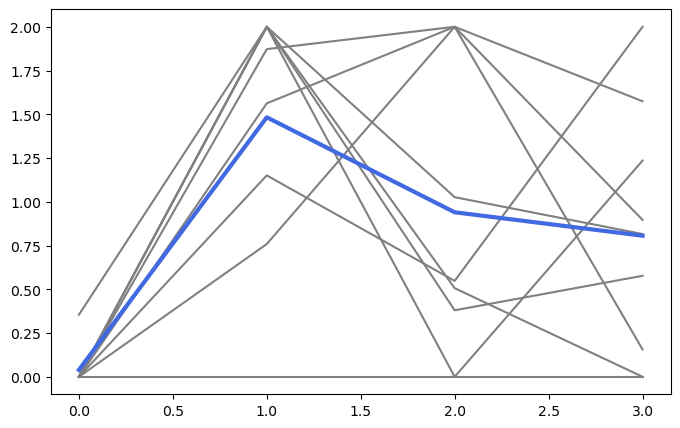

In [16]:
# Remove the last 3 quarters from the detrended data
detrended_no_outliers = detrended[:-3]
print(detrended_no_outliers.shape)  # Should be 37

# Recalculate the seasonal components if necessary
lows_index = [0,2,8,13,16,21,26,30,34,36]
lows = y_hist.index[lows_index]

period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows) - 1    
seasonals = np.empty((period, num_seasons))

for p in range(num_seasons):
    start_idx = lows_index[p]
    end_idx = start_idx + period
    s = detrended_no_outliers[start_idx:end_idx]
    
    # Check if the length of s matches the period
    if len(s) != period:
        print(f"Skipping segment {p} due to length mismatch: expected {period}, got {len(s)}")
        continue
    
    s = 2 * (s - np.min(s)) / (np.max(s) - np.min(s))
    seasonals[:, p] = s

mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8, 5))
for p in range(num_seasons):
    plt.plot(seasonals[:, p], color=0.5 * np.ones(3))
plt.plot(mean_seasonals, color='royalblue', linewidth=3)
plt.show()


In [17]:
# Initialize the seasonal series with float dtype

## THIS HAS ISSUE


##############################
seasonal = pd.Series(index=y_hist.index, data=0.0)

for low in lows_index:
    if low + period <= len(seasonal):
        seasonal[low:low + period] = mean_seasonals
    else:
        remaining_length = len(seasonal) - low
        seasonal[low:] = mean_seasonals[:remaining_length]

# Normalize the seasonal series
seasonal = seasonal / np.max(seasonal)

# Remove the last element from the seasonal series
seasonal = seasonal[:-1]

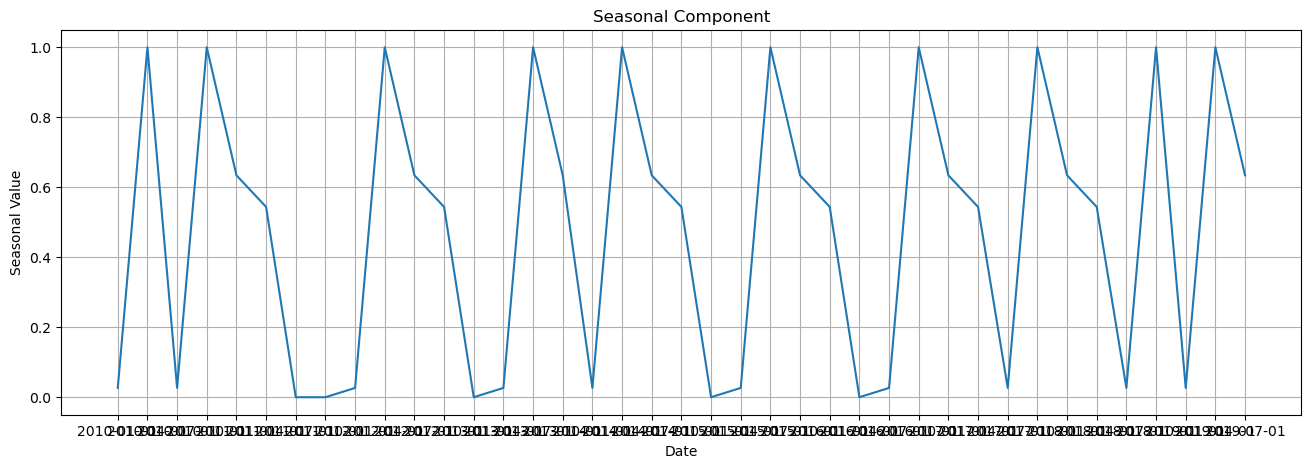

In [18]:
import sys
# sys.exit("Stopping the code here")

### THIS HAS ISSUE... 


###############################
# Ensure the index of seasonal is in string format if it's not already
if not isinstance(seasonal.index[0], str):
    seasonal.index = seasonal.index.astype(str)

# Plot the seasonal series
plt.figure(figsize=(16, 5))
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal Value')
plt.grid(True)
plt.show()



# DIFFERENT APPROACH USING SEASONAL DECOMPOSE LIBRARY


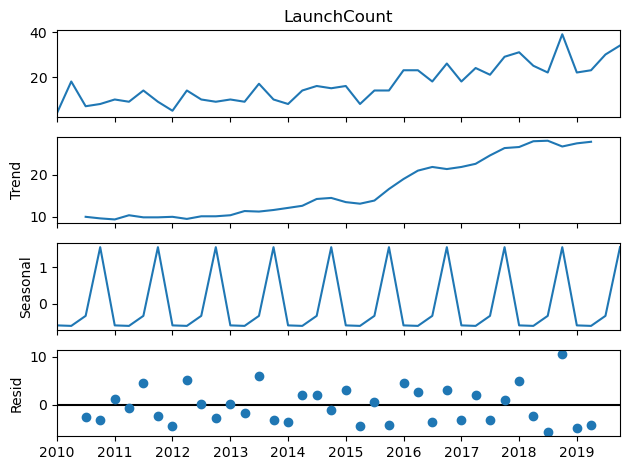

In [19]:
# Perform seasonal decomposition
result = seasonal_decompose(y_hist, model='additive', period=4)

# Plot the decomposed components
result.plot()
plt.show()

In [20]:
#instantiate
stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0), 'trend':"t"})
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(y_future))

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


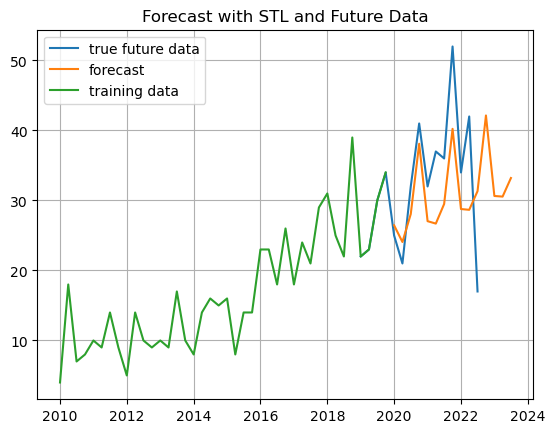

In [21]:
plt.plot(y_future, label = 'true future data')
plt.plot(forecast, label = 'forecast')
plt.plot(y_hist['1993':], label = 'training data')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid();

In [25]:
pred_error = y_future - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt(np.square(pred_error).mean())


# Answer check
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 7.070488640929349
RMSE: 8.297668783728618


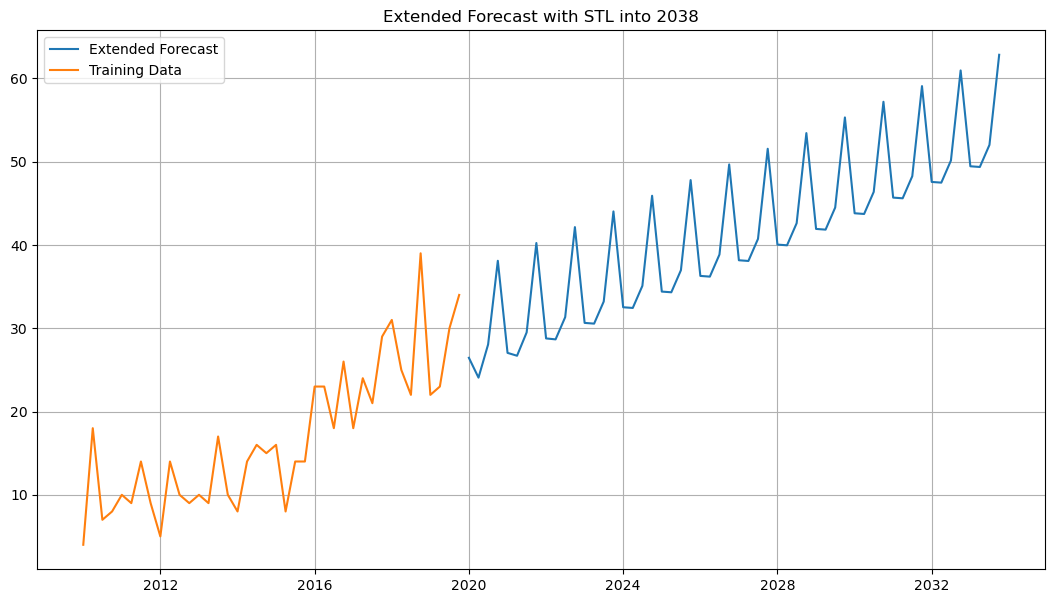

In [25]:
# calculate the number of future periods
n_quarters = 56  # for quarterly data until 2038 from 2024

# produce forecast for extended future data
extended_forecast = stlf_results.forecast(n_quarters)

# plot extended forecast
plt.figure(figsize=(13, 7))
plt.plot(extended_forecast, label='Extended Forecast')
plt.plot(y_hist['1993':], label='Training Data')
plt.legend()
plt.title('Extended Forecast with STL into 2038')
plt.grid();
plt.show()


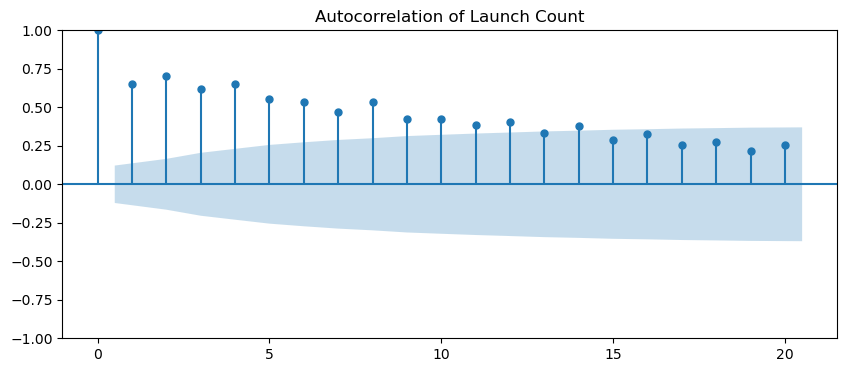

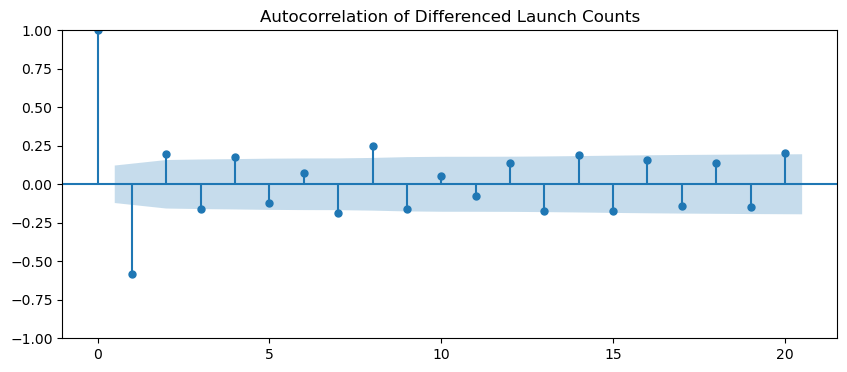

In [26]:
# Plot the autocorrelation of the differenced data
fig, ax = plt.subplots(figsize=[10, 4])
plot_acf(launch_counts_df['LaunchCount'], lags=20, ax=ax)
ax.set_title('Autocorrelation of Launch Count')
plt.show()

# Difference the 'Adj Close' column to make it stationary
launch_counts_df['LaunchCount_diff'] = launch_counts_df['LaunchCount'].diff()

# Drop the first row with NaN value resulting from differencing
lc_diff = launch_counts_df.dropna()

# Compute the autocorrelation of the differenced data
tsla_acf = acf(lc_diff['LaunchCount_diff'], nlags=20, fft=True)

# Plot the autocorrelation of the differenced data
fig, ax = plt.subplots(figsize=[10, 4])
plot_acf(lc_diff['LaunchCount_diff'], lags=20, ax=ax)
ax.set_title('Autocorrelation of Differenced Launch Counts')
plt.show()

## SARIMAX Models Using Full Date Range and Using "Space Race" Curve As a Multi Decade Season

In [47]:
X_train = launch_counts_df[:'2009-10-01'].drop(['Quarter','LaunchCount_diff'], axis=1)
X_train_space_race = launch_counts_df['1960-01-01':'1979-10-01'].drop(['Quarter','LaunchCount_diff'], axis=1)
X_test = launch_counts_df['2010':].drop(['Quarter','LaunchCount_diff'], axis=1)

print(X_train.tail())
print(X_test.head())

            LaunchCount
Datetime               
2008-10-01           11
2009-01-01           12
2009-04-01           11
2009-07-01           14
2009-10-01           13
            LaunchCount
Datetime               
2010-01-01            4
2010-04-01           18
2010-07-01            7
2010-10-01            8
2011-01-01           10


## ADFuller Test

In [28]:
# Perform the test
result = adfuller(X_train)

# Extract and print the results
adf_statistic, p_value, used_lag, n_obs, critical_values, ic_best = result
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}')


ADF Statistic: -2.430548848907034
p-value: 0.13329917762001658
Critical Values: {'1%': -3.4626576734812318, '5%': -2.8757444215841326, '10%': -2.5743412314098753}


### Description: 


ADF Statistic: -2.430548848907034
This is the test statistic for the ADF test. It is compared against the critical values to determine if the null hypothesis can be rejected.
p-value: 0.13329917762001658
The p-value indicates the probability of observing the test statistic under the null hypothesis. A higher p-value suggests that the null hypothesis cannot be rejected.
Critical Values:
1%: -3.4626576734812318
5%: -2.8757444215841326
10%: -2.5743412314098753
These values represent the thresholds for rejecting the null hypothesis at different significance levels (1%, 5%, and 10%).
Interpretation:
Null Hypothesis (H₀): The time series has a unit root (it is non-stationary).
Alternative Hypothesis (H₁): The time series does not have a unit root (it is stationary).
To determine if the series is stationary:

Compare the ADF Statistic with the Critical Values.
If the ADF Statistic is less than the critical value, you reject the null hypothesis.
In your case:

The ADF Statistic (-2.430548848907034) is not less than the critical values at the 1%, 5%, or 10% levels.
The p-value (0.13329917762001658) is greater than 0.05, indicating that you cannot reject the null hypothesis at the 5%

#### Conclusion:
The test suggests that the time series is non-stationary since you cannot reject the null hypothesis. significance level.

## Plotting Autocorrelation and Partial Autocorrelation

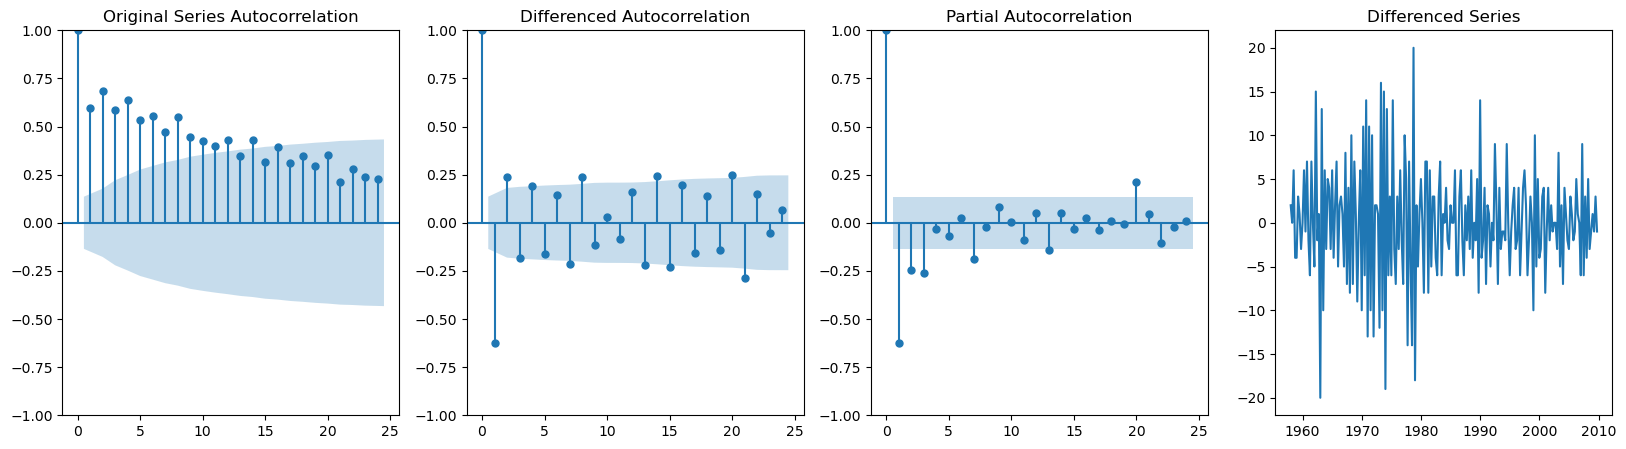

In [66]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(X_train, ax = ax[0]);
ax[0].set_title('Original Series Autocorrelation')
plot_acf(X_train.diff().dropna(), ax = ax[1]);
ax[1].set_title('Differenced Autocorrelation')
plot_pacf(X_train.diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(X_train.diff().dropna())
ax[3].set_title('Differenced Series');

### Description:

#### Original Series Autocorrelation:

Shows strong positive autocorrelation that decays slowly.
This suggests the series is non-stationary and likely has a trend.
The slow decay indicates persistence in the data, possibly due to a long-term trend or long memory process.


#### Differenced Autocorrelation:

The autocorrelation has been significantly reduced after differencing.
There's still some significant autocorrelation at certain lags, particularly at lag 1 (negative) and around lag 4 (positive).
This suggests that while differencing has removed much of the non-stationarity, there might still be some seasonal patterns.


#### Partial Autocorrelation:

Shows significant spikes at several lags, particularly at lag 1 and 4.
This suggests that an AR(1) model might be appropriate, but there could also be seasonal components at play.

In [67]:
# Prediction Without Seasonality

# Similar to: arma = ARIMA(X_train.diff(), order = (1,0,1)).fit() 
arma = SARIMAX(X_train.diff().dropna(), order=(1,0,1), simple_differencing=False).fit()

# Predict the values for the test data
preds = arma.predict(start=X_test.index[0], end=X_test.index[-1])

# Calculate the mean squared error on the test data
mse_test = mean_squared_error(X_test, preds)

### ANSWER CHECK
print(preds[:5])
print(mse_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97870D+00    |proj g|=  3.57090D-02

At iterate    5    f=  2.97672D+00    |proj g|=  1.09577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   6.606D-07   2.977D+00
  F =   2.9767137452836030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2010-01-01   -0.368038
2010-04-01    0.107093
2010-07-01   -0.031163
2010-10-01    0.009068
2011-01-01   -0.002639
Freq: QS-OCT, Nam

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


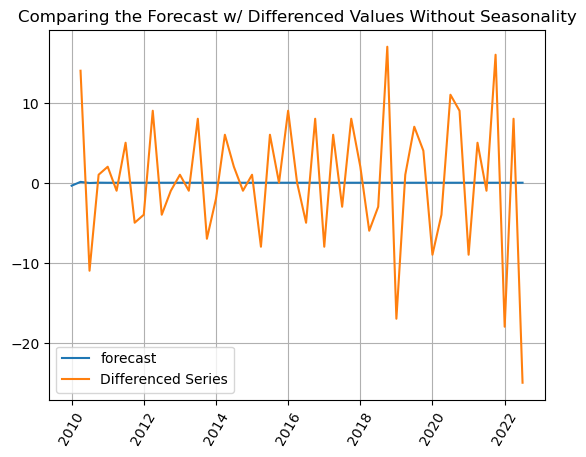

In [31]:
plt.plot(arma.forecast(steps = len(X_test)), label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.title('Comparing the Forecast w/ Differenced Values Without Seasonality')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

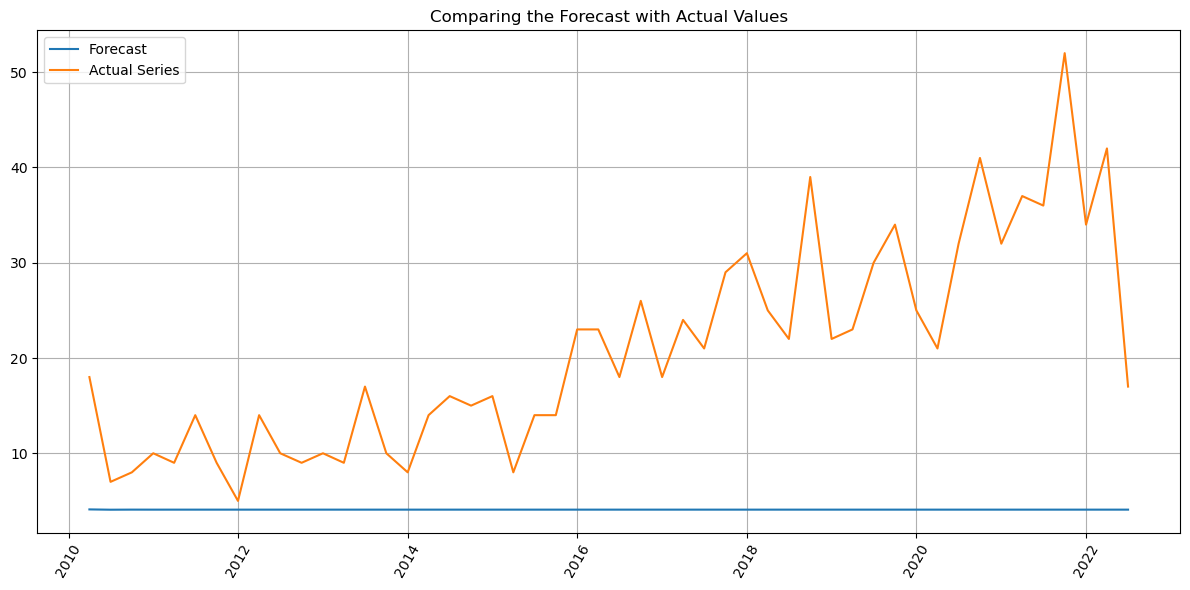

X_test_trimmed shape: (50, 1)
forecast_undifferenced shape: (50,)

First few values of X_test_trimmed:
            LaunchCount
Datetime               
2010-04-01           18
2010-07-01            7
2010-10-01            8
2011-01-01           10
2011-04-01            9

First few values of forecast_undifferenced:
Datetime
2010-04-01    4.107093
2010-07-01    4.075931
2010-10-01    4.084999
2011-01-01    4.082360
2011-04-01    4.083128
Name: predicted_mean, dtype: float64


In [38]:
# Create a Series for the forecast with the same index as X_test
forecast = arma.forecast(steps = len(X_test))
forecast_series = pd.Series(forecast, index=X_test.index[1:])

# Undo the differencing for the forecast
forecast_undifferenced = X_test.iloc[0].values[0] + forecast_series.cumsum()

# Ensure both series are the same length
X_test_trimmed = X_test.iloc[1:]  # Remove the first row to match forecast length

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_test_trimmed.index, forecast_undifferenced, label='Forecast')
plt.plot(X_test_trimmed.index, X_test_trimmed, label='Actual Series')
plt.title('Comparing the Forecast with Actual Values')
plt.legend()
plt.xticks(rotation=60)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the shapes to verify
print("X_test_trimmed shape:", X_test_trimmed.shape)
print("forecast_undifferenced shape:", forecast_undifferenced.shape)

# Print the first few values of each series
print("\nFirst few values of X_test_trimmed:")
print(X_test_trimmed.head())
print("\nFirst few values of forecast_undifferenced:")
print(forecast_undifferenced.head())

In [34]:

# Define the seasonal period as two decades
s = 80 # Number of quarters from Q1 1960 to Q1 1980 

# Set up and fit the SARIMAX model
sarma = SARIMAX(X_train,
                order=(1,1,1),              # Non-seasonal part (p,d,q)
                seasonal_order=(1,1,1,s),   # Seasonal part (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarma_fit = sarma.fit(disp=False)

# Print summary
print(sarma_fit.summary())

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                        LaunchCount   No. Observations:                  209
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 80)   Log Likelihood                -130.611
Date:                            Sun, 29 Sep 2024   AIC                            271.222
Time:                                    15:35:24   BIC                            280.365
Sample:                                10-01-1957   HQIC                           274.647
                                     - 10-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1354      0.312      0.434      0.664      -0.476       0.747
ma.L1         -0.6882      0.186   

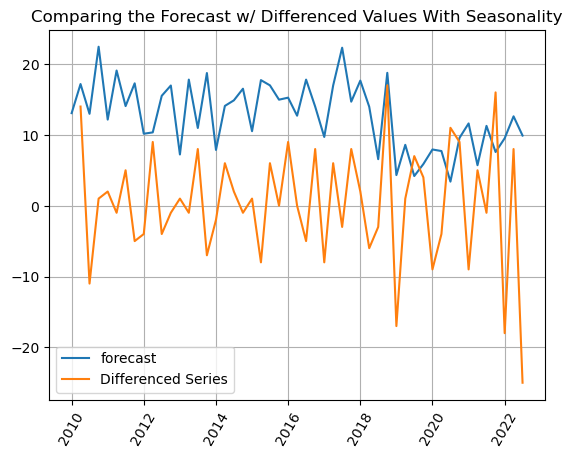

In [42]:
plt.plot(sarma_fit.forecast(steps = len(X_test)), label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.title('Comparing the Forecast w/ Differenced Values With Seasonality')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

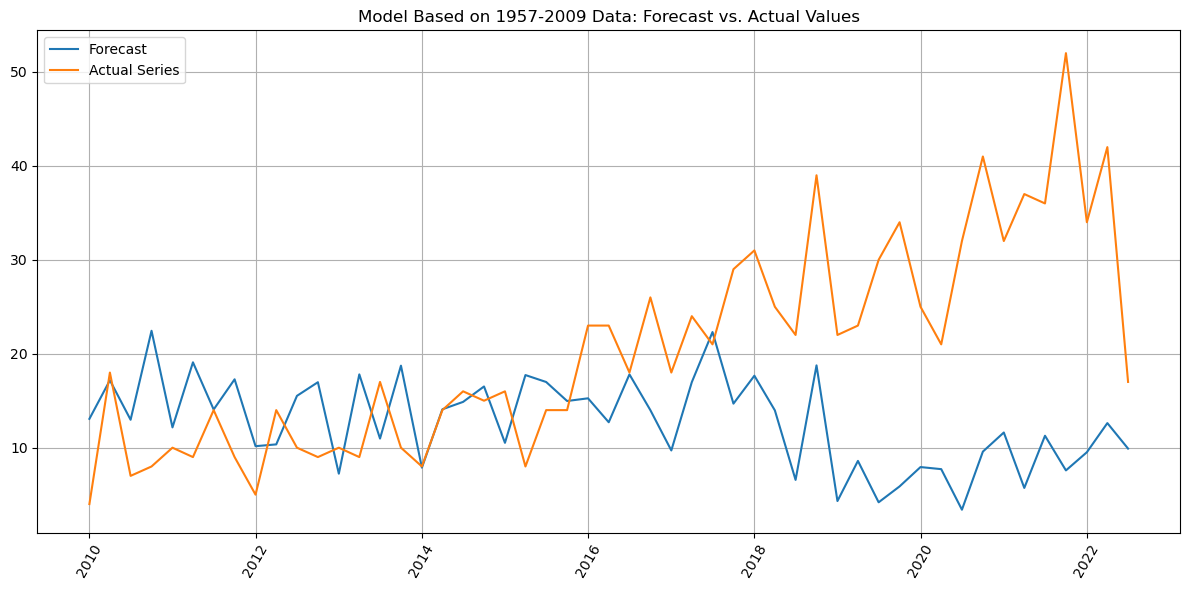

Mean Squared Error: 241.0982300276021
Root Mean Squared Error: 15.527338150101649


In [63]:

# Generate forecast
forecast2 = sarma_fit.forecast(steps=len(X_test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, forecast2, label='Forecast')
plt.plot(X_test.index, X_test, label='Actual Series')
plt.title('Model Based on 1957-2009 Data: Forecast vs. Actual Values')
plt.legend()
plt.xticks(rotation=60)
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the mean squared error on the test data
mse_test = mean_squared_error(X_test, forecast2)
print(f'Mean Squared Error: {mse_test}')
rmse = np.sqrt(mean_squared_error(X_test, forecast2))
print(f"Root Mean Squared Error: {rmse}")

In [48]:
# Define the seasonal period
s = 80  # Number of quarters from Q1 1960 to Q1 1980

# Set up and fit the SARIMAX model
sarma2 = SARIMAX(X_train_space_race,
                 order=(1,1,1),              # Non-seasonal part (p,d,q)
                 seasonal_order=(1,1,1,s),   # Seasonal part (P,D,Q,s)
                 enforce_stationarity=False,
                 enforce_invertibility=False)

# Fit the model
sarma_fit2 = sarma2.fit(disp=False)

# Print summary
print(sarma_fit2.summary())

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('

                                     SARIMAX Results                                      
Dep. Variable:                        LaunchCount   No. Observations:                   80
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 80)   Log Likelihood                   0.000
Date:                            Sun, 29 Sep 2024   AIC                             10.000
Time:                                    16:01:19   BIC                                nan
Sample:                                01-01-1960   HQIC                               nan
                                     - 10-01-1979                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tools/eval_measures.py:415: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tools/eval_measures.py:440: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3015: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3015: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:470: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/home/elmunoz42/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: Runtim

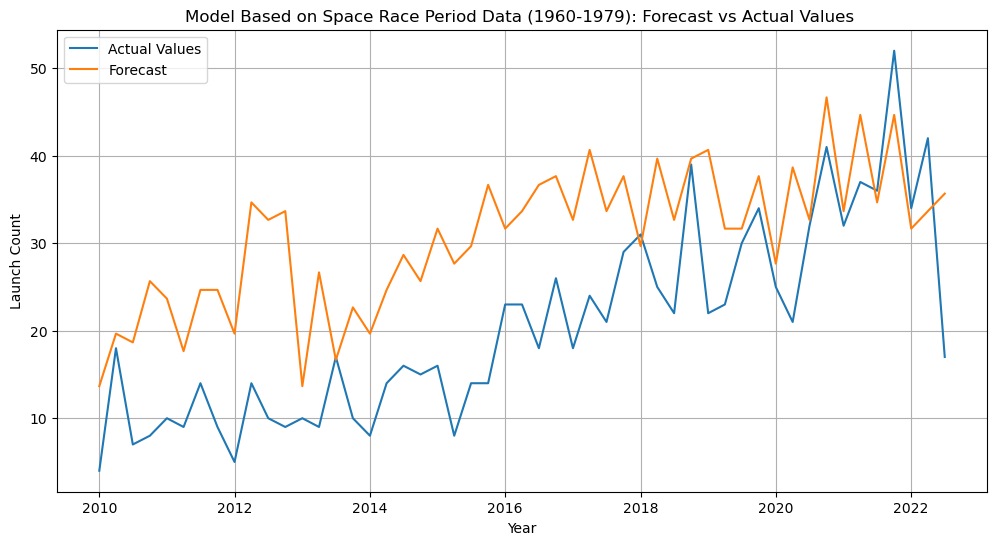

Number of observations: 79


In [58]:
# Generate forecast
forecast3 = sarma_fit2.forecast(steps=len(X_test))
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, X_test, label="Actual Values")
plt.plot(X_test.index, forecast3, label='Forecast')
plt.title('Model Based on Space Race Period Data (1960-1979): Forecast vs Actual Values ')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Launch Count')
plt.grid(True)
plt.show()

# Print the number of observations
print(f"Number of observations: {len(space_race_data)}")

In [61]:
# Calculate the mean squared error on the test data
mse_test = mean_squared_error(X_test, forecast3)
print(f'Mean Squared Error: {mse_test}')
rmse = np.sqrt(mean_squared_error(X_test, forecast3))
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 164.64052287581703
Root Mean Squared Error: 12.831232321013326


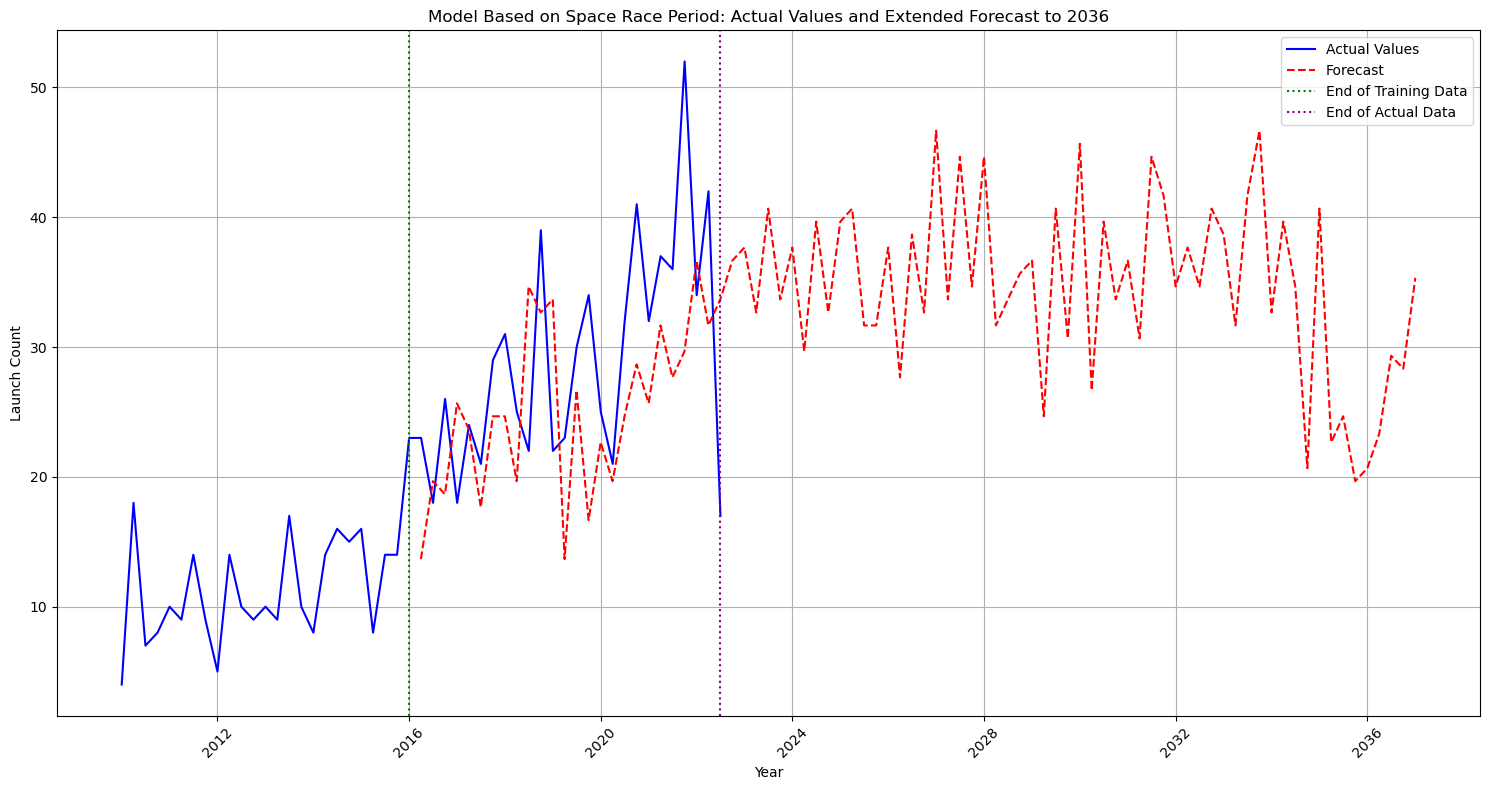

Number of observations in training data: 80
Number of actual observations in test period: 51
Number of forecasted steps: 84
Forecast range: 2016-03-31 00:00:00 to 2036-12-31 00:00:00


In [72]:
from pandas.tseries.offsets import QuarterEnd
# Generate forecast starting from the end of the training period to 2036
forecast_start = pd.to_datetime('2016-01-01')
forecast_end = pd.to_datetime('2036-12-31')
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='Q')
steps = len(forecast_index)

# Generate forecast
forecast_extended = sarma_fit2.forecast(steps=steps)
forecast_extended.index = forecast_index

# Combine actual values and forecast
combined_series = pd.concat([X_test, forecast_extended[forecast_extended.index > X_test.index[-1]]])

# Plot
plt.figure(figsize=(15, 8))

# Plot actual values up to 2022
plt.plot(X_test.index, X_test, label="Actual Values", color='blue')

# Plot forecast from 1980 to 2036
plt.plot(forecast_extended.index, forecast_extended, label='Forecast', color='red', linestyle='--')

# Add vertical lines
plt.axvline(x=pd.to_datetime('2016-01-01'), color='green', linestyle=':', label='End of Training Data')
plt.axvline(x=X_test.index[-1], color='purple', linestyle=':', label='End of Actual Data')

plt.title('Model Based on Space Race Period: Actual Values and Extended Forecast to 2036')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Launch Count')
plt.grid(True)

# Adjust x-axis to show more readable date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Print some information
print(f"Number of observations in training data: {len(sarma_fit2.model.endog)}")
print(f"Number of actual observations in test period: {len(X_test)}")
print(f"Number of forecasted steps: {len(forecast_extended)}")
print(f"Forecast range: {forecast_extended.index[0]} to {forecast_extended.index[-1]}")